In [1]:
import torch
from sklearn.metrics import jaccard_score as jsc
from tqdm import tqdm
import dataset
import utils
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
from torchmetrics.classification import MulticlassConfusionMatrix

C:\Users\eros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval_model(net, Loader_validation, device, batch_size=1, show_progress=False):
	# returns (macro, weighted) IoU
	macro = 0
	weighted = 0    
	net.eval()	
	# shape: N x H x W (960x224x224)
	normalized_confusion_metric = MulticlassConfusionMatrix(num_classes=16, normalize='true')
	flat_confusion_metric = MulticlassConfusionMatrix(num_classes=16)
	with torch.no_grad():
		for c in range(len(Loader_validation)):									
			dataset = Loader_validation.get_iterable_chunk(c)
			dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
			if show_progress:
				pbar = tqdm(total=len(dataset.chunk_crops)//batch_size, desc=f'Chunk {c+1}')
			for i,(x,y,_,context) in enumerate(dl):								
				x, y = x.to(device), y.to(device)
				if net.requires_context:
					context = context.to(device)
				y_pred = net(x.type(torch.float32), context.type(torch.float32))
				y_pred = y_pred.squeeze().cpu()
				_,pred_mask = torch.max(y_pred, dim=0)
				
				# update global tensor to compute overall mIoU
				p = pred_mask.unsqueeze(0).type(torch.int64).reshape(1,-1)
				t = y.squeeze(1).cpu().type(torch.int64).reshape(1,-1)
				try:
					normalized_confusion_metric.update(p, t)
					flat_confusion_metric.update(p,t)
				except:
					print("Something wrong with updating parameters")
					break
				prediction = pred_mask.cpu().numpy().reshape(-1)
				target = y.cpu().numpy().reshape(-1)
				weighted += jsc(target,prediction, average='weighted') # takes into account label imbalance				
				macro += jsc(target,prediction, average='macro') # simple mean over each class.
				if show_progress:
					pbar.update(1)
			if show_progress:
				pbar.close()
			print("Updating confusion matrix...")
			
	macro_score = macro / ((len(dataset.chunk_crops)*len(Loader_validation))// batch_size)
	weighted_score = weighted / ((len(dataset.chunk_crops)*len(Loader_validation))// batch_size)
	if show_progress:	
		pbar.close()
	# return macro_score, weighted_score, global_mask, global_pred
	return macro_score, weighted_score, flat_confusion_metric, normalized_confusion_metric

In [3]:
config = {
	"net": "Unetv2",
	"load_checkpoint": "D:\\weights\\checkpoint8",
	"device": "gpu",
	"num_classes": 15,
}
Loader_validation = dataset.Loader("D:\\Datasets\\GID15\\gid-15\\GID\Validation", 1, patch_size=224) # chunk size of 1 for validation to save RAM. No random shift.
device = utils.load_device(config)
net = utils.load_network(config, device)
utils.load_checkpoint(config, net)
#mIoU, wIoU, global_mask, global_pred= eval_model(net, Loader_validation, device, show_progress=True)
mIoU, wIoU, flat, normalized= eval_model(net, Loader_validation, device, show_progress=True)

Training network on NVIDIA GeForce GTX 1060 6GB
Loaded checkpoint D:\weights\checkpoint8
mIoU: [0.21187598585143255, 0.23996299989440648, 0.25341637794829514, 0.2905737813213422, 0.30515571338769987, 0.31818093201251546, 0.287597098177707, 0.32033303664648205]
wIoU: [0.49411081443048677, 0.5243016982938122, 0.5279968949742603, 0.5721189254807009, 0.5841055538358675, 0.6091675854883275, 0.544494886165453, 0.6021206211425487]
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS1__L1A0001064454-MSS1.tif


Chunk 1: 100%|██████████| 960/960 [00:53<00:00, 18.11it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS1__L1A0001118839-MSS1.tif


Chunk 2: 100%|██████████| 960/960 [00:53<00:00, 17.98it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS1__L1A0001395956-MSS1.tif


Chunk 3: 100%|██████████| 960/960 [00:52<00:00, 18.15it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS1__L1A0001680858-MSS1.tif


Chunk 4: 100%|██████████| 960/960 [00:52<00:00, 18.27it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS2__L1A0000718813-MSS2.tif


Chunk 5: 100%|██████████| 960/960 [00:53<00:00, 18.08it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS2__L1A0001378501-MSS2.tif


Chunk 6: 100%|██████████| 960/960 [00:53<00:00, 18.04it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS2__L1A0001471436-MSS2.tif


Chunk 7: 100%|██████████| 960/960 [00:53<00:00, 18.11it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS2__L1A0001517494-MSS2.tif


Chunk 8: 100%|██████████| 960/960 [00:52<00:00, 18.30it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS2__L1A0001787564-MSS2.tif


Chunk 9: 100%|██████████| 960/960 [00:52<00:00, 18.23it/s]


Updating confusion matrix...
Loading chunk:
D:\Datasets\GID15\gid-15\GID\Validation\Image__8bit_NirRGB\GF2_PMS2__L1A0001821754-MSS2.tif


Chunk 10: 100%|██████████| 960/960 [00:52<00:00, 18.23it/s]

Updating confusion matrix...


In [5]:
labels = {
	0:"unlabeled",
	1:"in. land",
	2:"u. residential",
	3:"r. residential",
	4:"tr. land",
	5:"p. field",
	6:"ir. crop",
	7:"dry crop",
	8:"g. plot",
	9:"a. woodland",
	10:"shrub land",
	11:"nat. g. land",
	12:"ar. g. land",
	13:"river",
	14:"lake",
	15:"pond",
}


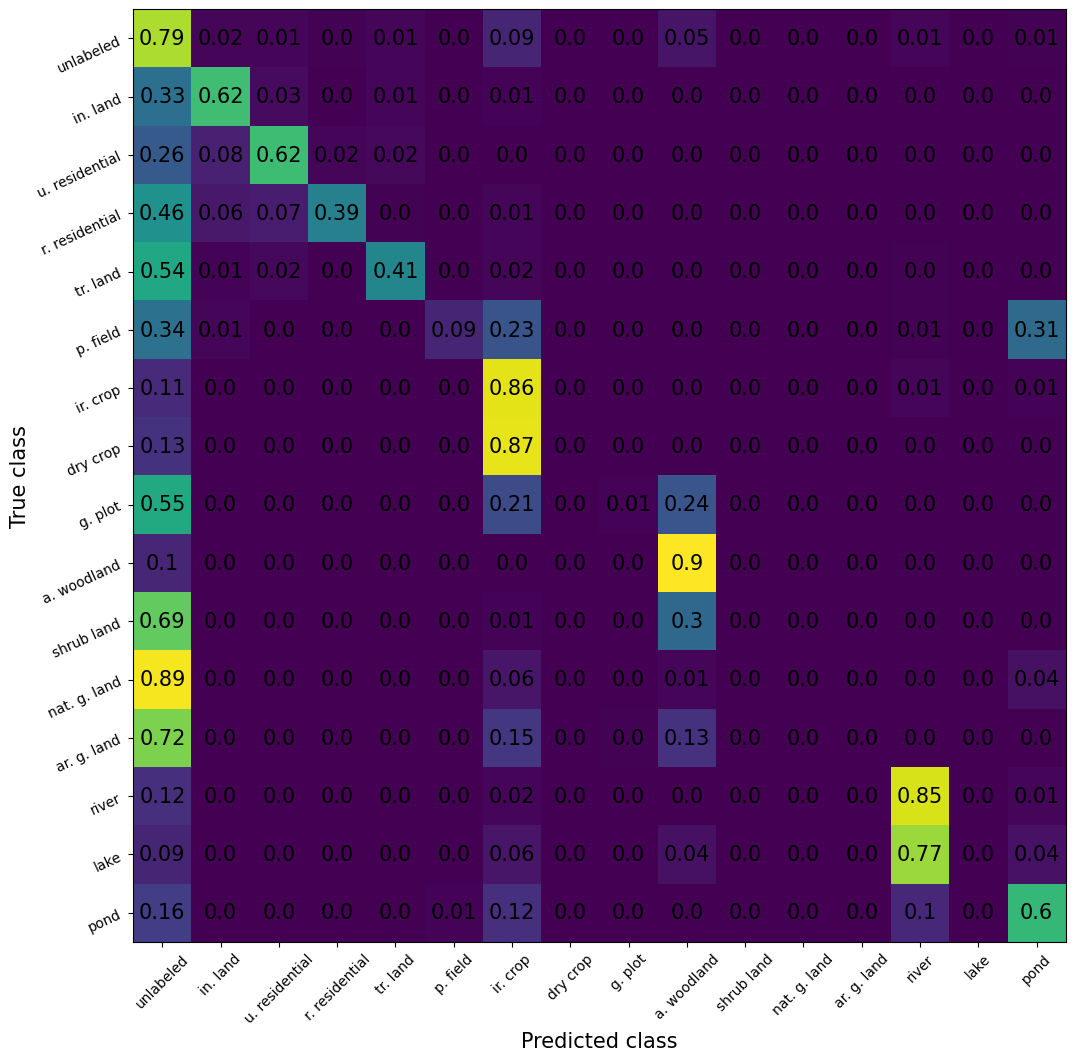

In [6]:
import matplotlib.pyplot as plt
fig_, ax_ = normalized.plot(labels = labels.values())
fig_.set_size_inches(18.5, 10.5)
plt.show()

In [61]:
def precision(confusion, macro=False):
	"""
	returns precision for each class
	"""
	precisions = []
	_, classes = list(confusion.shape)
	for i in range(classes):
		tp = confusion[i,i].item()
		fp = (torch.sum(confusion[:, i])-tp).item()
		if tp == 0:
			precisions.append(0)
		else:
			precisions.append(tp/(tp+fp))
	precisions = torch.tensor(precisions)
	if macro:
		return torch.mean(precisions).item()
	else:
		return precisions

def recall(confusion, macro=False):
	"""
	returns recall for each class
	"""
	recall = []
	_, classes = list(confusion.shape)
	for i in range(classes):
		tp = confusion[i,i].item()
		fn = (torch.sum(confusion[i,:])-tp).item()
		if tp == 0:
			recall.append(0)
		else:				
			recall.append(tp/(tp+fn))
	recall = torch.tensor(recall)
	if macro:
		return torch.mean(recall).item()
	else:
		return recall	


def IoU(confusion, mean=False, exclude_zeros=False):
	_, classes = list(confusion.shape)
	IoU = []
	for i in range(classes):
		tp = confusion[i,i].item()
		fp = (torch.sum(confusion[:, i])-tp).item()
		fn = (torch.sum(confusion[i,:])-tp).item()
		IoU.append(tp/(tp+fn+fp))
	IoU = torch.tensor(IoU)
	if exclude_zeros:
		IoU = IoU[IoU.nonzero()].squeeze()
	if mean:
		return torch.mean(IoU).item()
	else:
		return IoU

def F1(confusion, mean=False, exclude_zeros=False):
	_, classes = list(confusion.shape)
	scores = []
	for i in range(classes):
		tp = confusion[i,i].item()
		fp = (torch.sum(confusion[:, i])-tp).item()
		fn = (torch.sum(confusion[i,:])-tp).item()
		scores.append((2*tp)/(2*tp+fn+fp))
	scores = torch.tensor(scores)
	if exclude_zeros:
		scores = scores[scores.nonzero()].squeeze()
	if mean:
		return torch.mean(scores).item()
	else:
		return scores

def accuracy(confusion):
	_, classes = list(confusion.shape)
	correct_predictions = sum([confusion[i,i].item() for i in range(classes)])
	all_predictions = torch.sum(confusion).item()
	return correct_predictions/all_predictions

def macro_precision(confusion):
	p = precision(confusion)
	return torch.mean(p).item()

def macro_recall(confusion):
	r = recall(confusion)
	return torch.mean(r).item()

In [64]:
confusion = flat.compute() # get confusion matrix
print(precision(confusion, macro=True))
print(recall(confusion, macro=True))
print(IoU(confusion, mean=True, exclude_zeros=True))
print(F1(confusion, mean=True, exclude_zeros=True))
print(accuracy(confusion))

0.50437992811203
0.3845590353012085
0.30639103055000305
0.40669456124305725
0.6933811504338063
